In [3]:
%reload_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader
from DatasetClass import KITTI_MOD_FIXED, ExtendedKittiMod
from torch.nn import Sigmoid
# from torchmetrics import IoU
from sklearn.metrics import jaccard_score

data_root = "/storage/remote/atcremers40/motion_seg/datasets/Extended_MOD_Masks/"
dataset = ExtendedKittiMod(data_root, test=True)
batch_size = 2
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)


model_path = "/storage/remote/atcremers40/motion_seg/saved_models/28-12-2021_22-34_bs2/2_0.005_25.pt"
model = torch.load(model_path).to('cpu')
model.eval()

# needed to map to binary scores
sigmoid = Sigmoid()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# iou = IoU(num_classes=2)

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = torch.bitwise_and(outputs, labels).float().sum()  # Will be zero if Truth=0 or Prediction=0
    union = torch.bitwise_or(outputs, labels).float().sum()         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
        
    return iou

dirs loaded:
['2011_09_26_drive_0005_sync', '2011_09_26_drive_0013_sync', '2011_09_26_drive_0014_sync', '2011_09_26_drive_0015_sync', '2011_09_26_drive_0018_sync', '2011_09_26_drive_0032_sync', '2011_09_26_drive_0051_sync', '2011_09_26_drive_0056_sync', '2011_09_26_drive_0057_sync', '2011_09_26_drive_0059_sync', '2011_09_26_drive_0060_sync', '2011_09_26_drive_0084_sync']


In [4]:
with torch.no_grad():
    model.eval()
    test_iou = []
    for idx, (data, targets) in enumerate(loader):
        data = data.float()
        targets = targets.int()

        # forward
        scores = model(data)
        scores_rounded = torch.round(sigmoid(scores))
        scores_rounded = scores_rounded.int()
        iou = iou_pytorch(scores_rounded, targets)
        test_iou.append(iou)
        if idx == 10:
            break

print(f"aIoU: {sum(test_iou)/len(test_iou)}")

aIoU: 0.2719603478908539


## Visualize sample images

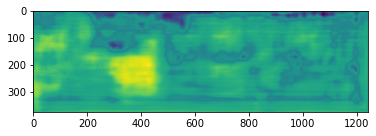

In [5]:
import matplotlib.pyplot as plt
data, _ = next(iter(loader))
scores = model(data)
plt.imshow(scores.detach().numpy()[0][0])
plt.show()